# Exploratory Data Analysis

Problem statement: **Predicting the total number of active e-scooter users**

## 1. Hypothesis Generation

Before approaching the problem, we first come up with several hypotheses that influence the demand for scooters:
- **Yearly trend**: Demand increases over the years
- **Weekly trend**: Demand is lower during weekends than weekdays
- **Daily trend**: Demand is lower during the wee hours/ office hours, higher during peak travel hours
- **Weather**: Demand is lower during rainy/ snowy season than during clear days
- **Temperature**: Demand is lower when temperature is too low/ too high
- **Pollution**: Demand is lower as pollution level increases

This will help us in thinking of what suitable plots are needed for the EDA.

## 2. Import libraries and explore dataset

Here, we seek to understand the variable types and values. This helps us in our subsequent steps when we clean our data for further exploration.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
df = pd.read_csv("dataset/rental_data.csv")
df.head(5)

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter
0,2012-07-02,23,clear,109.0,140.0,51.0,7.0,13,37,631
1,2011-12-22,10,cloudy,80.2,109.4,82.0,6.0,35,41,894
2,2011-02-25,11,clear,90.4,120.2,77.0,30.0,30,27,350
3,2012-03-10,1,clear,71.8,95.0,36.0,17.0,40,2,354
4,2011-06-19,5,cloudy,102.2,132.8,78.0,0.0,1,23,82


In [57]:
df.dtypes

date                       object
hr                          int64
weather                    object
temperature               float64
feels_like_temperature    float64
relative_humidity         float64
windspeed                 float64
psi                         int64
guest_scooter               int64
registered_scooter          int64
dtype: object

In [8]:
print('Shape before dropping duplicates:', df.shape)
df = df.drop_duplicates()
print('Shape after dropping duplicates:', df.shape)

Shape before dropping duplicates: (18643, 10)
Shape after dropping duplicates: (17031, 10)


In [61]:
print(df.isnull().sum())

date                      0
hr                        0
weather                   0
temperature               0
feels_like_temperature    0
relative_humidity         0
windspeed                 0
psi                       0
guest_scooter             0
registered_scooter        0
dtype: int64


## 3. Data Cleaning and Correlation

To analyse the time-series nature of the data, we need to sort it  by date and hour. Here, we aggregate the date and hour to form a new column *date_hr* and set it as the **index**.

In [3]:
# index by date and time
df['hr'] = [format(i, "02") for i in df['hr']] 
df['date_hr'] = pd.to_datetime(df['date'] + ' ' + df['hr'], format = '%Y%m%d %H')
df = df.set_index('date_hr').sort_index()

We also realise that the values for the *weather* column have capitalisation differences and spelling errors. Thus, we clean them for analysis.

In [4]:
print('Unique weather conditions before cleaning: \n', df['weather'].unique())

def cleanWeather(word):
    word = word.lower()
    if word == 'lear' or word == 'clar':
        return 'clear'
    elif word == 'loudy' or word == 'cludy':
        return 'cloudy'
    elif word == 'liht snow/rain':
        return 'light snow/rain'
    else:
        return word

df['weather'] = df['weather'].apply(cleanWeather)

print('\nUnique weather conditions after cleaning: \n', df['weather'].unique())

Unique weather conditions before cleaning: 
 ['clear' 'lear' 'cloudy' 'light snow/rain' 'CLOUDY' 'CLEAR' 'clar'
 'LIGHT SNOW/RAIN' 'loudy' 'heavy snow/rain' 'cludy' 'liht snow/rain']

Unique weather conditions after cleaning: 
 ['clear' 'cloudy' 'light snow/rain' 'heavy snow/rain']


It does not make sense for the number of e-scooter users to be negative. Thus, we use a forward fill method to replace these negative values. Since the user numbers follow a cyclical pattern, forward filling seems like a good option.

In [5]:
# forward fill for no. of users < 0 
df[df[['guest_scooter','registered_scooter']] < 0] = np.nan
df[['guest_scooter','registered_scooter']] = df[['guest_scooter','registered_scooter']].ffill(axis = 0) 

,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter
temperature,1.000000,0.987837,-0.065630,-0.023332,-0.001644,0.456933,0.333847
feels_like_temperature,0.987837,1.000000,-0.047583,-0.062577,-0.002612,0.451245,0.331060
relative_humidity,-0.065630,-0.047583,1.000000,-0.288192,-0.002247,-0.344568,-0.272163
windspeed,-0.023332,-0.062577,-0.288192,1.000000,-0.006077,0.089534,0.083682
psi,-0.001644,-0.002612,-0.002247,-0.006077,1.000000,-0.005724,-0.012674
guest_scooter,0.456933,0.451245,-0.344568,0.089534,-0.005724,1.000000,0.502759
registered_scooter,0.333847,0.331060,-0.272163,0.083682,-0.012674,0.502759,1.000000


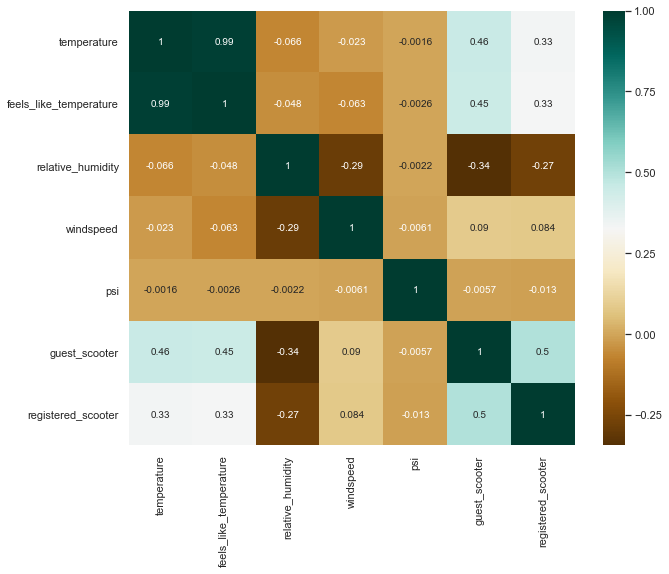

In [6]:
plt.figure(figsize=(10,8))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

- High correlation between temperature and feels_like_temperature

We will remove *feels_like_temperature* in our modelling process to prevent **multi-collinearity**.

## 4. Hypothesis Testing

### (1) Yearly trend

We plot the no. of users over time.

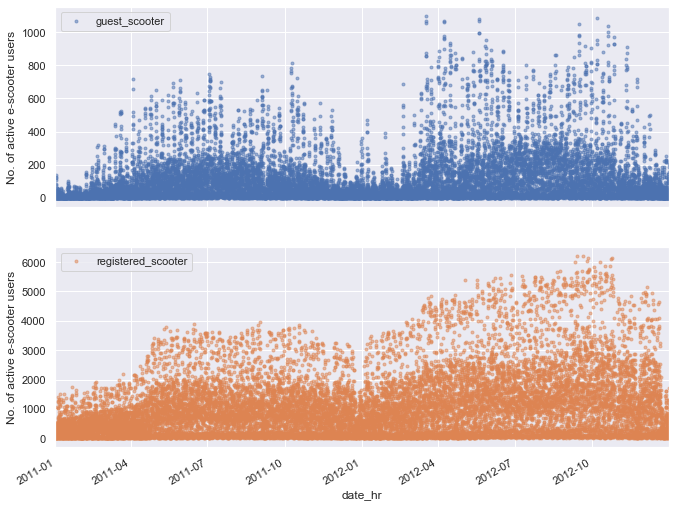

In [66]:
cols_plot = ['guest_scooter', 'registered_scooter']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('No. of active e-scooter users')

Some interesting patterns:
- Demand increases over time, but with seasonal trends in data and a sizeable portion of outliers
- Demand increases going into the year and decreases as the year comes to an end

The boxplot analysis of no. of users per month confirms the above insights.

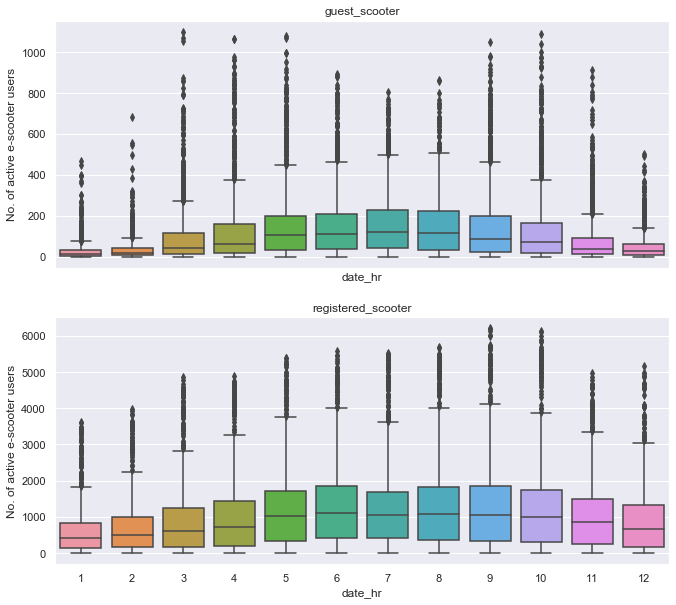

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['guest_scooter', 'registered_scooter'], axes):
    sns.boxplot(data=df, x=df.index.month, y=name, ax=ax)
    ax.set_ylabel('No. of active e-scooter users')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

- Median no. of active users increases from January to July, and decreases till December.
- A sizeable number of outliers in demand

Thus, in our feature engineering process, we can add a new variable - **year + quarter** - to bin the data.

### (2) **Weekly trend**

To understand the trends in a week, we find the day based on the date. Boxplots are created to understand the distribution.

In [69]:
import datetime  
from datetime import date 
import calendar 
  
def findDay(date): 
    year, month, day = (int(i) for i in date.split('-'))     
    dt = datetime.date(year, month, day) 
    return dt.strftime("%A")

df['day'] = [findDay(i) for i in df['date']] 

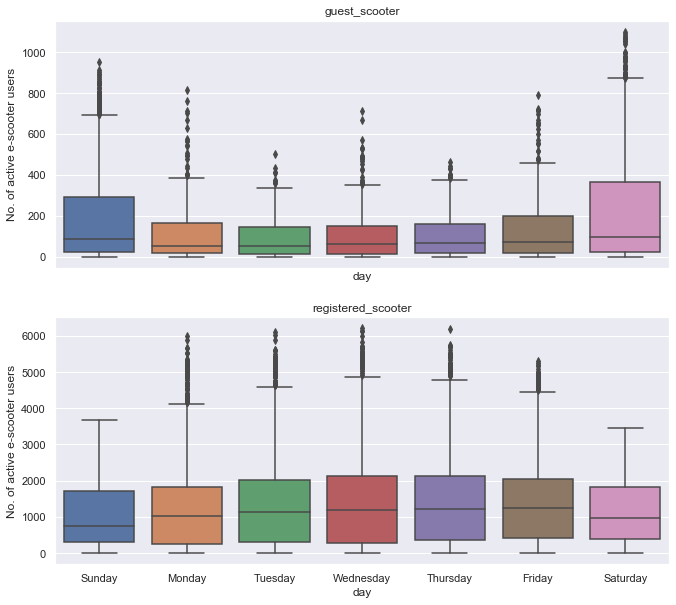

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['guest_scooter', 'registered_scooter'], axes):
    sns.boxplot(data=df.loc['2012'], x='day', y=name, ax=ax)
    ax.set_ylabel('No. of active e-scooter users')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

In a week,

- **Guest users**: Higher median and standard deviation over the weekends than weekdays
- **Registered users**: Higher median and standard deviation over weekdays than weekends

This means that in our feature engineering process, we can split the data into **2 bins - weekdays and weekends** - rather than having 7 values representing days of the week.

### (3) Daily trend

Throughout the day, there should be variation in demand for scooters. We use boxplots to understand the variation.

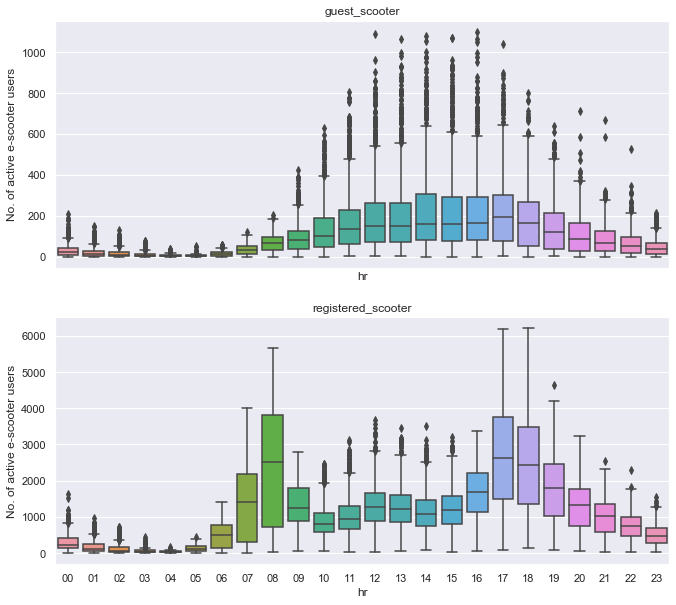

In [71]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['guest_scooter', 'registered_scooter'], axes):
    sns.boxplot(data=df, x='hr', y=name, ax=ax)
    ax.set_ylabel('No. of active e-scooter users')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

In a day,

- **Both groups**: No. is lower during the wee hours than day time
- **Guest users**: Median no. shows a gradual increasing then decreasing trend over the day
- **Registered users**: Spike in demand during morning and evening peak hours (7-8am and 5-7pm)
- No. of guest users show more variation compared to no. of registered users

This means that in our feature engineering process, we can group the hours into bins to reduce the number of feature levels.

### (4) Weather

We use bar charts to understand the relationship between weather and demand for scooters.

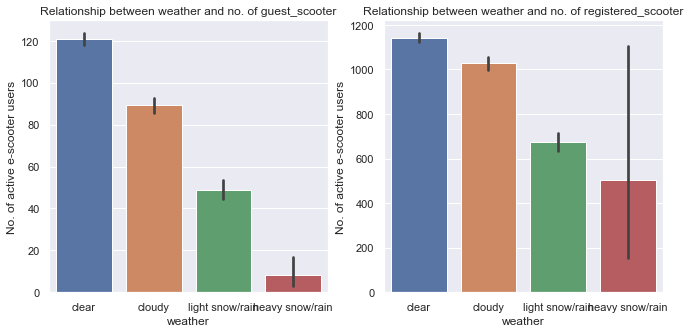

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharex=True)
for name, ax in zip(['guest_scooter', 'registered_scooter'], axes):
    sns.barplot(data=df, x='weather', y=name, ax=ax)
    ax.set_ylabel('No. of active e-scooter users')
    ax.set_title('Relationship between weather and no. of {0}'.format(name))

- Demand is higher when the weather is clear than when it is rainy/snowy

Thus, in our feature engineering process, we can maintain these bins.

### (5)-(6) Temperature, Pollution



Text(0, 0.5, 'No. of active e-scooter users')

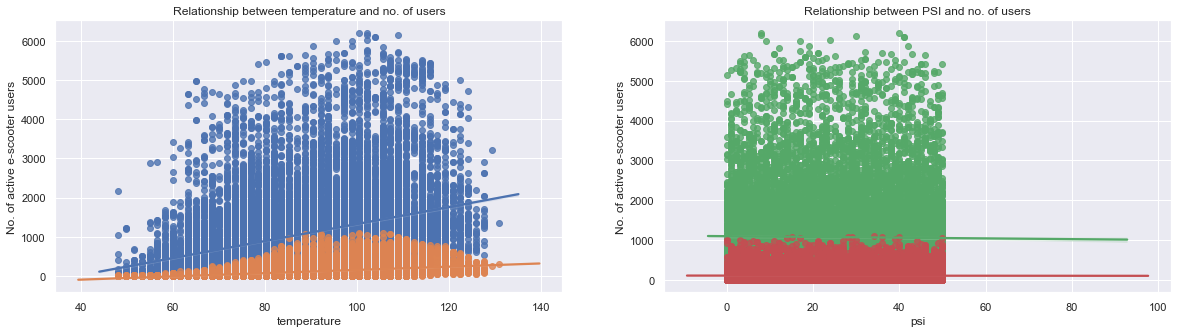

In [11]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 5)
sns.regplot(x="temperature", y="registered_scooter", data=df,ax=ax1)
sns.regplot(x="temperature", y="guest_scooter", data=df,ax=ax1)
sns.regplot(x="psi", y="registered_scooter", data=df,ax=ax2)
sns.regplot(x="psi", y="guest_scooter", data=df,ax=ax2)
ax1.set_title('Relationship between temperature and no. of users')
ax2.set_title('Relationship between PSI and no. of users')
ax1.set_ylabel('No. of active e-scooter users')
ax2.set_ylabel('No. of active e-scooter users')

- **Temperature**: Overall trend of increasing demand with temperature increase. However, we also see that the demand falls as temperature rises above 105 degree Fahrenheit. 
- **Pollution**: Demand does not seem to change with pollution levels. This could be due to the already low pollution levels in the area.

Thus, in our feature engineering process we can group the temperature variable into bins to reduce the number of feature levels.

## 5. Time-Series Visualization

In time-series modelling, it is important to understand whether the data displays **trend and seasonality** patterns. In particular, we need the data to be **stationary** before modelling. Strictly speaking it should conform to this set of criteria:

1. constant mean
2. constant variance
3. constant autocorrelation

The non-stationary nature of data is mainly caused by trend and seasonality. 

### (1) Plot rolling statistic

We can **plot the rolling statistics** to determine its pattern. Here, we take the rolling window of 24 to find the moving average/standard deviation for the past 24 hours (i.e. 1 day).

In [22]:
sns.set(rc={'figure.figsize':(11, 4)})
def plot_stationarity(timeseries, user):
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for {0}'.format(user))
    plt.show(block=False)

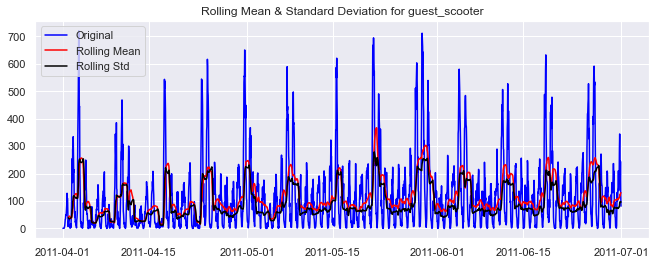

In [23]:
plot_stationarity(df.loc['2011-04':'2011-06','guest_scooter'], 'guest_scooter')

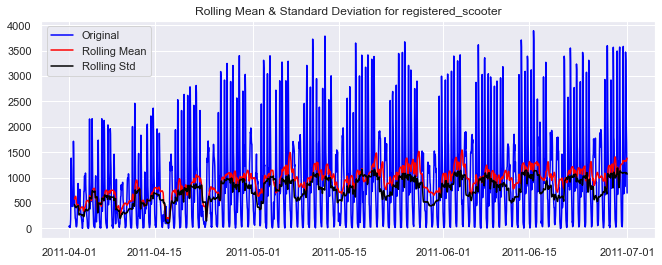

In [24]:
plot_stationarity(df.loc['2011-04':'2011-06','registered_scooter'], 'registered_scooter')

I use only three months of data because using all the data makes the plot less intuitive. Here, we can see that there is no constant mean (red) and no constant variance (black measured by standard deviation). This chart reveals that the data is **non-stationary**.

### (2) Smoothing to reduce trend

Thus, in our modelling process we can apply **smoothing** to the data to reduce its **trend**. One method is to use exponentially weighted moving average, where we give more weight to the most recent values.

#### Guest users

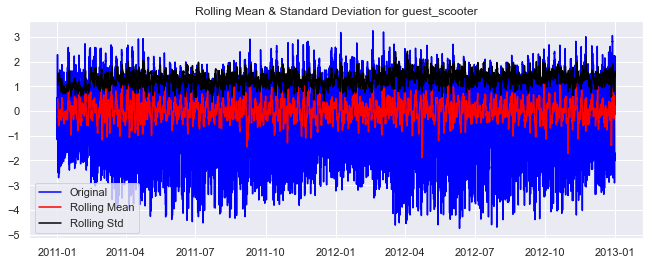

In [31]:
glog = np.log1p(df['guest_scooter'])
gexpwighted_avg = glog.ewm(halflife = 24).mean()
gewma_diff = glog - gexpwighted_avg
plot_stationarity(gewma_diff, 'guest_scooter')

#### Registered users

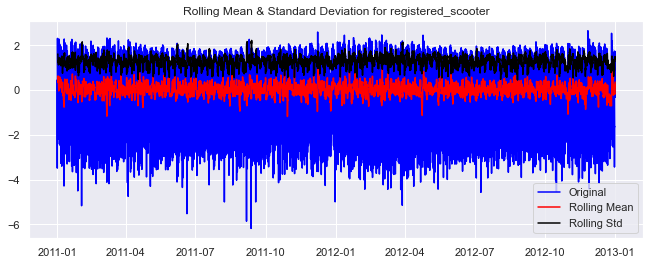

In [35]:
rlog = np.log1p(df['registered_scooter'])
rexpwighted_avg = rlog.ewm(halflife = 24).mean()
rewma_diff = rlog - rexpwighted_avg
plot_stationarity(rewma_diff, 'registered_scooter')

### (3) Differencing to reduce trend and seasonality

Another method is to use **differencing** on the data to reduce trend and seasonality. Here, we take the difference between the current instant and the previous instant.

#### Guest users

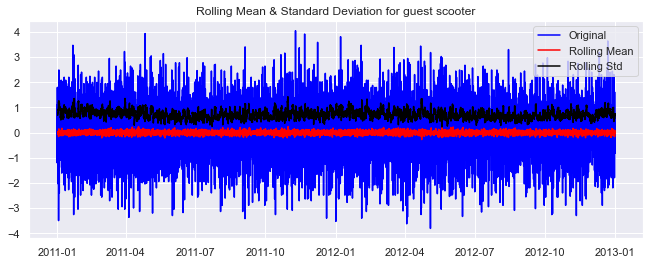

In [34]:
glog_diff = glog - glog.shift()
glog_diff.dropna(inplace=True)
plot_stationarity(glog_diff, 'guest scooter')

#### Registered users

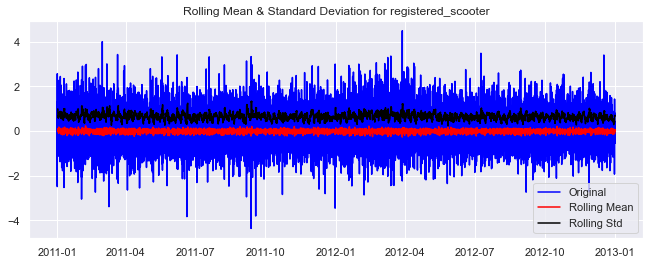

In [42]:
rlog_diff = rlog - rlog.shift()
rlog_diff.dropna(inplace=True)
plot_stationarity(rlog_diff, 'registered_scooter')

Now, we see that the mean and standard deviation remains relatively constant.

### (4) Determining the values for ARIMA modelling

The ARIMA (Auto-Regressive Integrated Moving Averages) model is a forecasting technique that uses past values to predict future values. Its parameters include p (no. of auto-regressive terms), q (no. of moving average terms) and d (no. of differences). We can determine the p and q values using the **Autocorrelation Function** (ACF) and **Partial Autocorrelation Function** (PACF).

In [36]:
from statsmodels.tsa.stattools import acf, pacf

#### Guest users

C:\Users\weich\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


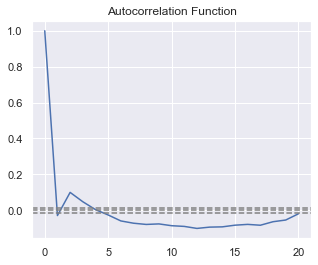

In [39]:
glag_acf = acf(glog_diff, nlags=20)
glag_pacf = pacf(glog_diff, nlags=20, method='ols')

def plot_acf(lag, diff):
    plt.subplot(121) 
    plt.plot(lag)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

plot_acf(glag_acf, glog_diff)

From this chart, we can determine the q value (where the **ACF** chart crosses the upper confidence interval for the first time). Here, **q = 1**.

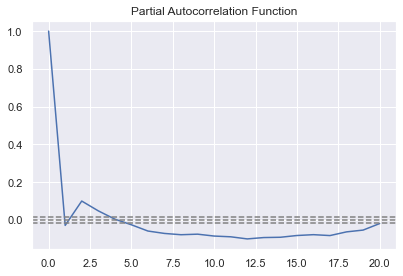

In [40]:
def plot_pacf(lag, diff):
    plt.subplot(122)
    plt.plot(lag)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
plot_pacf(glag_acf, glog_diff)

From this chart, we can determine the p value (where the **PACF** chart crosses the upper confidence interval for the first time). Here, **p = 1**.

#### Registered users

C:\Users\weich\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


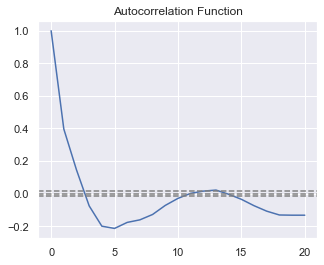

In [43]:
rlag_acf = acf(rlog_diff, nlags=20)
rlag_pacf = pacf(rlog_diff, nlags=20, method='ols')
plot_acf(rlag_acf, rlog_diff)

From this chart, we can determine the q value (where the **ACF** chart crosses the upper confidence interval for the first time). Here, **q = 2.5**.

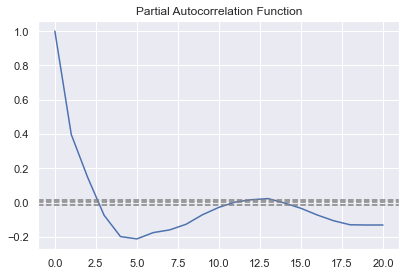

In [44]:
plot_pacf(rlag_acf, rlog_diff)

From this chart, we can determine the p value (where the **PACF** chart crosses the upper confidence interval for the first time). Here, **p = 2.5**.